In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import f1_score, recall_score, precision_score
import json

# Define the root directory of the dataset
root_dir = "E:/openpose_ten"

# Define image size and other constants
IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CLASSES = 2  # Total number of classes
FRAMES_PER_VIDEO = 30
BATCH_SIZE = 8
EPOCHS = 50
learning_rate = 0.001
num_channels = 3


# Define the number of classes
classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
num_classes = len(classes)
print("Total number of classes:", num_classes)


Total number of classes: 2


In [2]:
# Create an instance of ImageDataGenerator with the desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to create a data generator with augmentation
def data_generator(file_list, img_height, img_width, frames_per_video, batch_size, augment=False):
    while True:
        X_batch = []
        y_batch = []

        for file_path, class_index in file_list:
            frames = []
            for frame in sorted(os.listdir(file_path)):
                frame_path = os.path.join(file_path, frame)
                image = load_img(frame_path, target_size=(img_height, img_width))
                image = img_to_array(image)
                
                if augment:
                    image = datagen.random_transform(image)

                frames.append(image)

            if len(frames) == frames_per_video:
                X_batch.append(frames)
                y_batch.append(class_index)

                if len(X_batch) == batch_size:
                    X_batch = np.array(X_batch, dtype=np.float32) / 255.0
                    y_batch = to_categorical(y_batch, num_classes=NUM_CLASSES)
                    yield X_batch, y_batch
                    X_batch = []
                    y_batch = []

# Load file paths and class indices
def load_file_paths(root_dir):
    file_paths = []
    class_names = sorted(os.listdir(root_dir))
    
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(root_dir, class_name)
        video_folders = os.listdir(class_dir)
        
        for video_folder in video_folders:
            video_path = os.path.join(class_dir, video_folder)
            file_paths.append((video_path, class_index))
    
    return file_paths, class_names

file_paths, class_names = load_file_paths(root_dir)


In [3]:
# Define a function to create the model
# Define a function to create the model
def create_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(FRAMES_PER_VIDEO, IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))  # Reduced number of LSTM units and added recurrent dropout
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))  # Adjusted dropout rate
    model.add(Dense(2, activation='softmax'))  # Output layer with number of classes units
    return model

model = create_model()
model.summary()


D:\anaconda\envs\tf\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 30, 62, 62, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 31, 31, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 29, 29, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 30, 14, 14, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 30, 12, 12, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 30, 6, 6, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 30, 2304)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         606,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 634,338 (2.42 MB)

 Trainable params: 634,338 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:

# Train the model on the entire dataset
def train_model(model, train_generator, val_generator, steps_per_epoch, validation_steps):
    # Early stopping and model checkpoint
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True)

    # Train the model with callbacks
    #model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=learning_rate), metrics=['accuracy'])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=[early_stopping, checkpoint]
    )

    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])

    return model, history.history, best_val_acc, best_val_loss

# Prepare the dataset
train_paths, val_paths = train_test_split(file_paths, test_size=0.2, random_state=42)
steps_per_epoch = len(train_paths) // BATCH_SIZE
validation_steps = len(val_paths) // BATCH_SIZE

train_generator = data_generator(train_paths, IMG_HEIGHT, IMG_WIDTH, FRAMES_PER_VIDEO, batch_size=BATCH_SIZE, augment=True)
val_generator = data_generator(val_paths, IMG_HEIGHT, IMG_WIDTH, FRAMES_PER_VIDEO, batch_size=BATCH_SIZE, augment=False)

#model = create_model()  # Initialize the model once
model, history, best_val_acc, best_val_loss = train_model(model, train_generator, val_generator, steps_per_epoch, validation_steps)

# Save the model after training
model.save('model_v1_ten.keras')

print(f"Best validation accuracy: {best_val_acc}")
print(f"Best validation loss: {best_val_loss}")

# Evaluate the final model
def evaluate_model(model, val_generator, validation_steps):
    y_true = []
    y_pred = []

    for i in range(validation_steps):
        X_batch, y_batch = next(val_generator)
        y_true.append(np.argmax(y_batch, axis=1))
        y_pred.append(np.argmax(model.predict(X_batch), axis=1))

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return y_true, y_pred

# Final evaluation on the entire validation set
y_true, y_pred = evaluate_model(model, val_generator, validation_steps)

# Compute metrics
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')

print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Save metrics
metrics = {
    'f1_score': f1,
    'recall': recall,
    'precision': precision,
    'best_val_accuracy': best_val_acc,
    'best_val_loss': best_val_loss
}

save_dir = 'mediapipe_models'
os.makedirs(save_dir, exist_ok=True)

metrics_path = os.path.join(save_dir, 'metrics_mediapipe_v1_ten.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

# Save the final model
final_model_path = os.path.join(save_dir, 'final_model_mediapipe_v1_ten.keras')
model.save(final_model_path)

# Save training history for plotting
history_path = os.path.join(save_dir, 'history_mediapipe_v1_ten.json')
with open(history_path, 'w') as f:
    json.dump(history, f)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4940 - loss: 0.7182 - val_accuracy: 0.3750 - val_loss: 0.7147
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4110 - loss: 0.6974 - val_accuracy: 0.3750 - val_loss: 0.7172
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5199 - loss: 0.6946 - val_accuracy: 0.3750 - val_loss: 0.7137
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5667 - loss: 0.6956 - val_accuracy: 0.3750 - val_loss: 0.7243
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5667 - loss: 0.6881 - val_accuracy: 0.3750 - val_loss: 0.7057
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6074 - loss: 0.6737 - val_accuracy: 0.3750 - val_loss: 0.7141
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5815 - loss: 0.6818 - val_accuracy: 0.3750 - val_loss: 0.7057
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5955 - loss: 0.6956 - val_accuracy: 0.3750 - val_loss: 0.6945
Epoch 9/

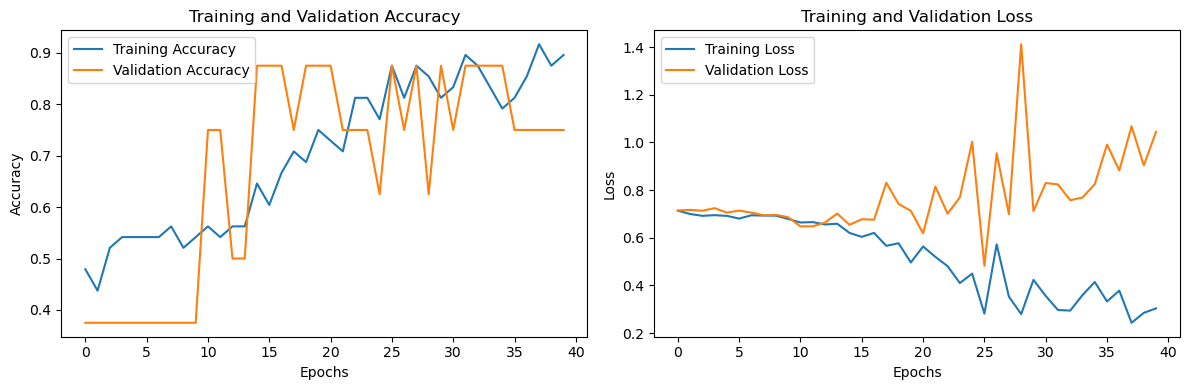

In [5]:
import matplotlib.pyplot as plt
import json
import os

# Load the training history
save_dir = 'mediapipe_models'
history_path = os.path.join(save_dir, 'history_mediapipe_v1_ten.json')
with open(history_path, 'r') as f:
    history = json.load(f)

# Plot the training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()
